In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

This `MultiHeadSelfAttention` module splits the input into multiple attention heads, where each head computes scaled dot-product attention independently. Queries (Q), Keys (K), and Values (V) are derived using linear projections, and attention scores are computed using QK^T / √d followed by softmax. The attended values are then concatenated and passed through a final linear transformation to obtain the output. Dropout is applied.


In [5]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** 0.5

        # Q, K, V
        self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)


        self.W_o = nn.Linear(embed_dim, embed_dim, bias=False)  #After concatenation

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_length, embed_dim = x.shape

        # Q, K, V
        Q = self.W_q(x).reshape(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_k(x).reshape(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).reshape(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Dot-Product Attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        attention_output = torch.matmul(attention_probs, V)
        attention_output = attention_output.transpose(1, 2).contiguous().reshape(batch_size, seq_length, embed_dim)

        return self.W_o(attention_output)



This `PatchEmbedding` module divides an image into fixed-size patches and projects them into an embedding space using a convolutional layer. It adds a learnable class token and positional encoding to retain spatial information. The positional encoding is generated using sine and cosine functions. The final output is a sequence of patch embeddings with positional information, ready for a transformer-based model.

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = self._generate_positional_encoding(num_patches + 1, embed_dim)

    def _generate_positional_encoding(self, seq_length, dim):
        pos = torch.arange(0, seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))
        pe = torch.zeros(seq_length, dim)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        return nn.Parameter(pe.unsqueeze(0), requires_grad=False)

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        return x



The `TransformerBlock` is a fundamental unit in Vision Transformers (ViTs), responsible for learning spatial dependencies across image patches. It consists of two main components:

1. **Multi-Head Self-Attention (MHSA):** This mechanism allows the model to attend to different parts of the input, capturing global relationships between patches.
2. **Feed-Forward Network (FFN):** A two-layer MLP with a **GELU activation function**, which enhances expressivity by smoothly approximating ReLU while allowing small negative values.

The architecture follows a **residual connection-based design**, with layer normalization applied before MHSA and FFN. GELU is particularly important in the FFN as it introduces non-linearity without abrupt thresholding, making training more stable and improving convergence in deep models.


In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


The `VisionTransformer` processes images by first converting them into patch embeddings using the `PatchEmbedding` layer. These embeddings are then passed through a sequence of Transformer blocks, where self-attention mechanisms capture spatial dependencies between patches. A LayerNorm is applied before the final classification, where the CLS token is extracted and passed through a fully connected layer for classification. This architecture allows the model to learn global representations efficiently without relying on convolutional layers.

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=256, num_heads=8, num_blocks=6, num_classes=10):
        super().__init__()
        self.embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(num_blocks)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x[:, 0])  # Extract CLS token
        return self.head(x)


In [9]:

def train_vit():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    transform = ToTensor()
    dataset = MNIST(root='./datasets', train=True, download=True, transform=transform)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    test_set = MNIST(root='./datasets', train=False, download=True, transform=transform)


    train_loader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2)


    model = VisionTransformer().to(device)
    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Best Model Tracking
    best_val_acc = 0
    best_model_path = "best_vit_mnist.pth"


    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Training
    for epoch in trange(10, desc="Training"):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
            x, y = x.to(device), y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            optimizer.zero_grad()   # Backward Pass
            loss.backward()
            optimizer.step()


            train_loss += loss.item()
            correct_train += (y_hat.argmax(1) == y).sum().item()
            total_train += y.size(0)

        train_acc = correct_train / total_train * 100
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                val_loss += criterion(y_hat, y).item()
                correct_val += (y_hat.argmax(1) == y).sum().item()
                total_val += y.size(0)

        val_acc = correct_val / total_val * 100
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


        if val_acc > best_val_acc:   # Save best model based on validation accuracy
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at {best_model_path} with Val Acc: {best_val_acc:.2f}%")

    print("Training completed!")


    model.load_state_dict(torch.load(best_model_path))    # Best Model for Testing
    print(f"Evaluating the best model: {best_model_path}")


    model.eval()    # Test
    correct_test, total_test, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            test_loss += criterion(y_hat, y).item()
            correct_test += (y_hat.argmax(1) == y).sum().item()
            total_test += y.size(0)

    test_acc = correct_test / total_test * 100
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

    #Training & Validation Curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    return model, test_loader






In [10]:

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid()

    # Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.3MB/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.21MB/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



Training:  10%|█         | 1/10 [06:38<59:42, 398.07s/it]

Epoch 1 | Train Loss: 1.5250 | Train Acc: 44.90% | Val Loss: 0.4243 | Val Acc: 87.20%
Best model saved at best_vit_mnist.pth with Val Acc: 87.20%



Training:  20%|██        | 2/10 [13:23<53:37, 402.21s/it]

Epoch 2 | Train Loss: 0.2815 | Train Acc: 91.37% | Val Loss: 0.2126 | Val Acc: 93.90%
Best model saved at best_vit_mnist.pth with Val Acc: 93.90%



Training:  30%|███       | 3/10 [20:03<46:50, 401.50s/it]

Epoch 3 | Train Loss: 0.1589 | Train Acc: 95.15% | Val Loss: 0.1286 | Val Acc: 96.22%
Best model saved at best_vit_mnist.pth with Val Acc: 96.22%



Training:  40%|████      | 4/10 [26:51<40:23, 403.96s/it]

Epoch 4 | Train Loss: 0.1168 | Train Acc: 96.39% | Val Loss: 0.1185 | Val Acc: 96.33%
Best model saved at best_vit_mnist.pth with Val Acc: 96.33%



Training:  50%|█████     | 5/10 [33:41<33:51, 406.20s/it]

Epoch 5 | Train Loss: 0.0920 | Train Acc: 97.21% | Val Loss: 0.1013 | Val Acc: 97.05%
Best model saved at best_vit_mnist.pth with Val Acc: 97.05%



Training:  60%|██████    | 6/10 [40:21<26:55, 403.99s/it]

Epoch 6 | Train Loss: 0.0747 | Train Acc: 97.68% | Val Loss: 0.0985 | Val Acc: 97.07%
Best model saved at best_vit_mnist.pth with Val Acc: 97.07%



Training:  70%|███████   | 7/10 [47:01<20:07, 402.62s/it]

Epoch 7 | Train Loss: 0.0630 | Train Acc: 98.05% | Val Loss: 0.0802 | Val Acc: 97.57%
Best model saved at best_vit_mnist.pth with Val Acc: 97.57%



Training:  80%|████████  | 8/10 [53:39<13:22, 401.38s/it]

Epoch 8 | Train Loss: 0.0533 | Train Acc: 98.35% | Val Loss: 0.1050 | Val Acc: 97.05%



Training:  90%|█████████ | 9/10 [1:00:16<06:39, 399.85s/it]

Epoch 9 | Train Loss: 0.0529 | Train Acc: 98.31% | Val Loss: 0.0957 | Val Acc: 97.00%



Training: 100%|██████████| 10/10 [1:06:52<00:00, 401.27s/it]

Epoch 10 | Train Loss: 0.0421 | Train Acc: 98.63% | Val Loss: 0.0774 | Val Acc: 98.00%
Best model saved at best_vit_mnist.pth with Val Acc: 98.00%
Training completed!
Evaluating the best model: best_vit_mnist.pth



<ipython-input-9-1c72c5dfddf2>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))    # Best Model for Testing


Test Loss: 0.0640 | Test Accuracy: 98.23%


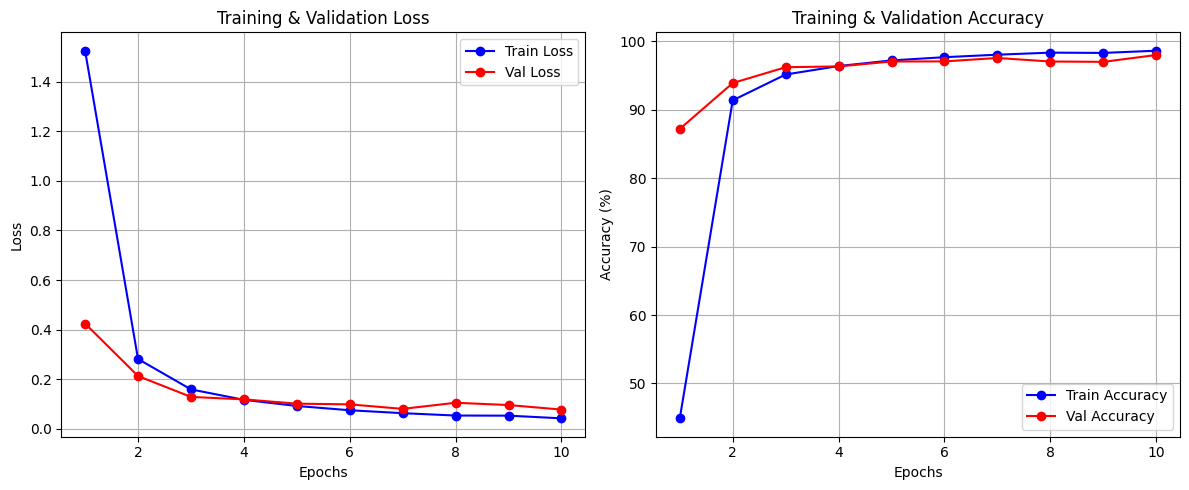

In [11]:
if __name__ == "__main__":
    trained_model, test_loader = train_vit()

## Results

The results indicate a well-performing model with a test accuracy of 98.23% and a low test loss of 0.0640, suggesting strong generalization. The training and validation loss curves show a rapid decline, stabilizing around epoch 4, indicating effective convergence. Similarly, the accuracy plot demonstrates quick improvement, reaching near saturation after a few epochs, with validation accuracy closely following training accuracy, implying minimal overfitting.

The `saliency maps` function highlights the most influential pixels in the model’s decision-making process. The model assigns higher gradients to key features of the digits, showing which regions contributed the most to predictions.

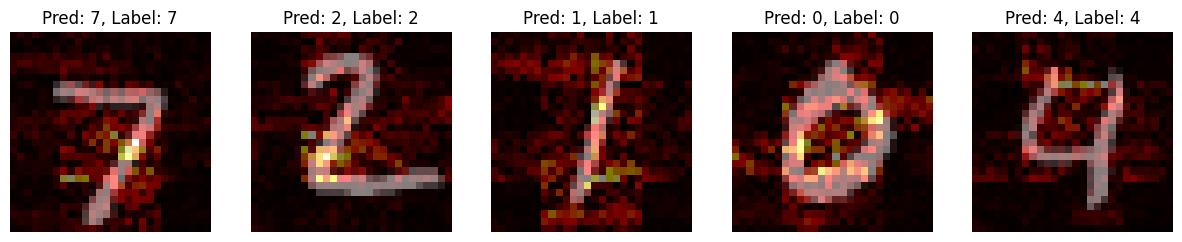

In [ ]:
def saliency_maps(model, test_loader, num_images=5):
    model.eval()
    samples, labels = next(iter(test_loader))
    samples, labels = samples[:num_images].to("cuda"), labels[:num_images].to("cuda")

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        sample = samples[i].unsqueeze(0)
        sample.requires_grad_()

        output = model(sample)
        pred_class = output.argmax(1).item()
        output[:, pred_class].backward()

        saliency = sample.grad.abs().squeeze().cpu().numpy()

        # plotting saliency map
        axes[i].imshow(samples[i].cpu().squeeze(), cmap="gray")
        axes[i].imshow(saliency, cmap="hot", alpha=0.5)
        axes[i].set_title(f"Pred: {pred_class}, Label: {labels[i].item()}")
        axes[i].axis("off")

    plt.show()

saliency_maps(trained_model, test_loader)


The bright yellow and red regions indicate areas where the model is most sensitive in making its prediction. These are the pixels that had the highest gradient magnitude with respect to the model’s output.The saliency map focuses on the main stroke structure of each digit, which aligns with human intuition.

Some digits (e.g., "0") show broader importance regions, suggesting the model considers more distributed pixel information.
Others, like "7" and "1", have more localized importance regions, indicating reliance on specific strokes.

The `integrated_gradients` (IG) method attributes pixel importance by comparing the model’s response to a black baseline image. It computes gradients over interpolated images between the baseline and input, averaging them to estimate feature importance. The resulting heatmap highlights which regions contributed most to the model’s prediction.

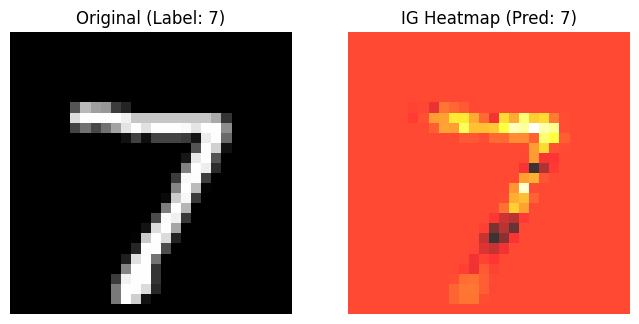

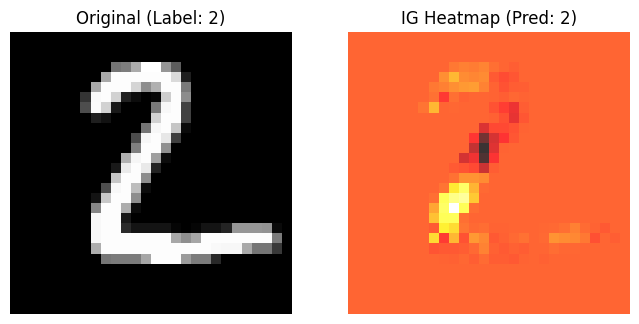

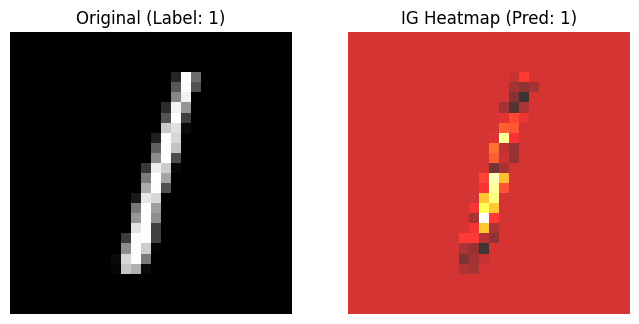

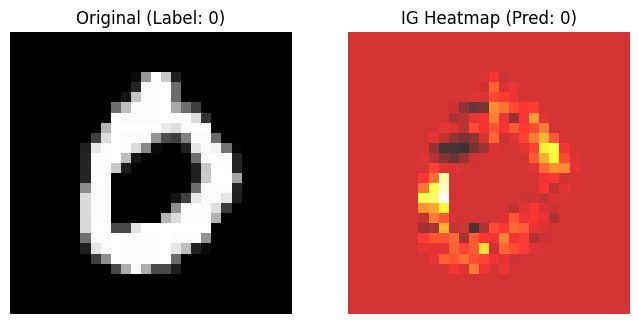

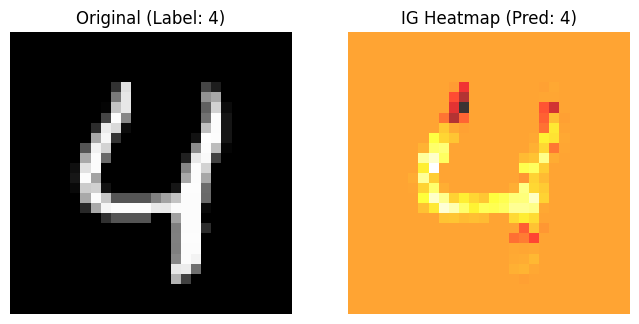

In [ ]:
def integrated_gradients(model, test_loader, num_images=5, steps=50):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    samples, labels = next(iter(test_loader))
    samples, labels = samples[:num_images].to(device), labels[:num_images].to(device)

    baseline = torch.zeros_like(samples).to(device)  # Baseline: Completely black image

    for i in range(num_images):
        sample = samples[i].unsqueeze(0)  #(1, 1, 28, 28)
        label = labels[i].item()

        # Interpolation
        interpolated = torch.cat([
            baseline[i].unsqueeze(0) + (float(j) / steps) * (sample - baseline[i].unsqueeze(0))
            for j in range(steps + 1)
        ], dim=0).to(device)  # (steps+1, 1, 28, 28)

        interpolated.requires_grad_()
        output = model(interpolated)
        pred_class = output[-1].argmax().item()


        model.zero_grad()
        output[:, pred_class].sum().backward(retain_graph=True)

        avg_gradients = interpolated.grad.mean(dim=0)
        attributions = (sample - baseline[i].unsqueeze(0)) * avg_gradients
        attributions = attributions.squeeze().cpu().detach().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].imshow(sample.cpu().squeeze(), cmap="gray")
        ax[0].set_title(f"Original (Label: {label})")
        ax[0].axis("off")

        ax[1].imshow(attributions, cmap="hot", alpha=0.8)
        ax[1].set_title(f"IG Heatmap (Pred: {pred_class})")
        ax[1].axis("off")

        plt.show()


integrated_gradients(trained_model, test_loader)


Brighter areas indicate higher importance in classification, while darker regions contribute less. The heatmaps align well with the digit’s structure, showing that the model is focusing on the relevant regions.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load best model
model = VisionTransformer().to(device)
model.load_state_dict(torch.load("best_vit_mnist.pth"))
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-13-32672b8d117f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_mnist.pth"))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.95      0.99      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



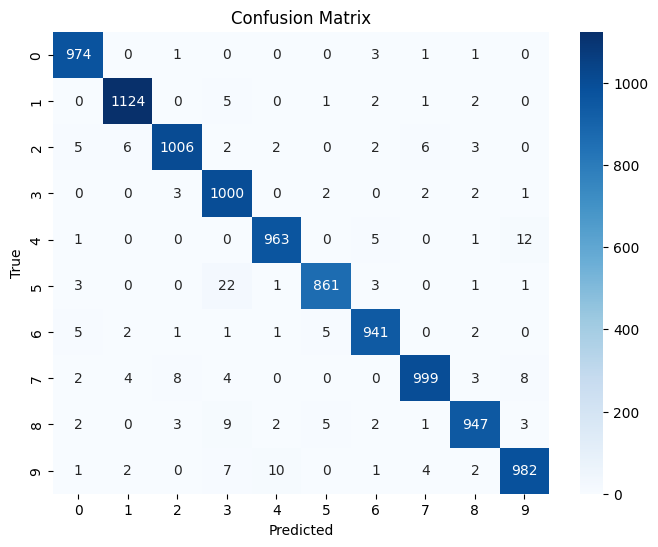

In [ ]:
def evaluate_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            y_pred.extend(y_hat.argmax(1).cpu().numpy())
            y_true.extend(y.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Confusion Matrix Analysis
evaluate_confusion_matrix(trained_model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")


The confusion matrix shows that the model performs well, with most predictions aligning with the true labels. Misclassifications are minimal, but some errors appear for digits like 5,9 etc, which might share visual similarities with other digits. The overall strong diagonal pattern indicates high accuracy in digit recognition.

In [2]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

This code applies the FGSM adversarial attack to generate perturbed images and test the model's robustness. The Fast Gradient Sign Method (FGSM) generates adversarial examples by adding small perturbations in the direction of the gradient to maximize model error.The adversarial samples highlight the model's vulnerability to small perturbations, which can mislead predictions.

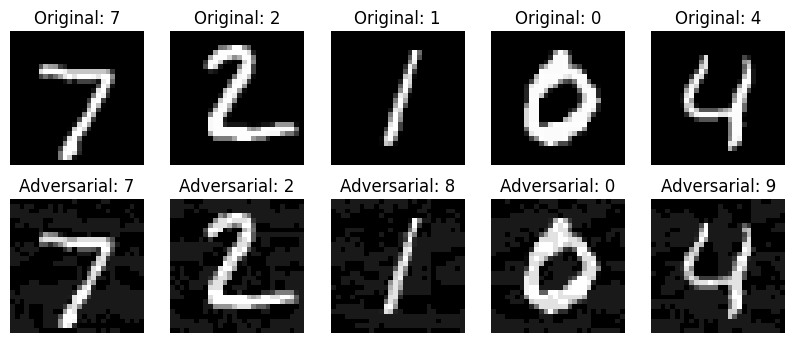

In [12]:
import torchattacks

def adversarial_attack(model, test_loader, device):
    model.eval()
    sample, label = next(iter(test_loader))
    sample, label = sample[:5].to(device), label[:5].to(device)

    attack = torchattacks.FGSM(model, eps=0.1)
    adv_images = attack(sample, label)

    adv_preds = model(adv_images).argmax(dim=1)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(sample[i].cpu().squeeze(), cmap="gray")
        axes[0, i].set_title(f"Original: {label[i].item()}")
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_images[i].cpu().squeeze(), cmap="gray")
        axes[1, i].set_title(f"Adversarial: {adv_preds[i].item()}")
        axes[1, i].axis("off")

    plt.show()

# Adversarial Robustness Analysis
adversarial_attack(trained_model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")


The results show how the FGSM adversarial attack perturbs the input images with minimal noise, causing misclassifications in some cases (e.g., "1" misclassified as "8" and "4" as "9"), while others remain correctly classified, indicating varying robustness across different digits.